## GAN for MNIST

Reference
- https://github.com/goodfeli/adversarial
- https://github.com/ckmarkoh/GAN-tensorflow/blob/master/gan.py
- http://www.kdnuggets.com/2016/07/mnist-generative-adversarial-model-keras.html

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Data loading

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
dim_image = 784

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Data visualiation

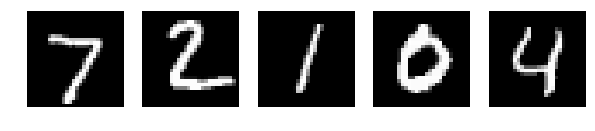

In [3]:
plt.rcParams['figure.figsize'] = (10, 2)
fig, ax_list = plt.subplots(1, 5)
for i in range(5):
    image = mnist.test.images[i].reshape((28, 28))
    label = np.argmax(mnist.test.labels[i])
    ax_list[i].axis('off')
    ax_list[i].imshow(image, cmap='gray')
plt.show()

### GAN

In [4]:
class GAN:
    def __init__(self, dim_z, dim_g_h1, dim_g_h2, dim_x, dim_d_h1, dim_d_h2):
        self.dim_z    = dim_z
        self.dim_g_h1 = dim_g_h1
        self.dim_g_h2 = dim_g_h2
        self.dim_x    = dim_x
        self.dim_d_h1 = dim_d_h1
        self.dim_d_h2 = dim_d_h2
        
        # Placeholders
        self.x = tf.placeholder(tf.float32, [None, self.dim_x])
        self.z = tf.placeholder(tf.float32, [None, self.dim_z])
        self.lr = tf.placeholder(tf.float32) # Learning rate
        self.dr = tf.placeholder(tf.float32) # Dropout rate
        
        # Generator
        G_init = tf.truncated_normal_initializer(stddev=0.1)
        with tf.variable_scope('G'):
            G_h1    = tf.layers.dense(self.z, self.dim_g_h1,
                                      activation=tf.tanh, kernel_initializer=G_init)
            
            G_h2    = tf.layers.dense(G_h1,   self.dim_g_h2,
                                      activation=tf.tanh, kernel_initializer=G_init)
            
            self.G  = tf.layers.dense(G_h2,   self.dim_x,
                                      activation=tf.tanh,    kernel_initializer=G_init)
        
        # Discriminator
        D_init = tf.truncated_normal_initializer(stddev=0.1)
        with tf.variable_scope('D') as scope:
            def discriminator(inputs):
                D_h1 = tf.layers.dense(inputs, self.dim_d_h1, activation=tf.tanh,
                                       kernel_initializer=D_init, name='D_h1')
                D_h1 = tf.nn.dropout(D_h1, 1 - self.dr, name='D_h1_dropout')
                
                D_h2 = tf.layers.dense(D_h1,   self.dim_d_h2, activation=tf.tanh,
                                       kernel_initializer=D_init, name='D_h2')
                D_h2 = tf.nn.dropout(D_h2, 1 - self.dr, name='D_h2_dropout')
                
                D    = tf.layers.dense(D_h2,   1, activation=tf.sigmoid,
                                       kernel_initializer=D_init, name='D')
                return D
            
            self.D_real = discriminator(self.x)
            scope.reuse_variables()
            self.D_fake = discriminator(self.G)
        
        # Losses
        self.loss_G      = tf.reduce_mean(-tf.log(self.D_fake))
        self.loss_D_real = tf.reduce_mean(-tf.log(self.D_real))
        self.loss_D_fake = tf.reduce_mean(-tf.log(1 - self.D_fake))
        self.loss_D      = tf.reduce_mean((self.loss_D_real, self.loss_D_fake))
        
        # Optmizers
        def optimizer(loss, var_list):
            return tf.train.AdamOptimizer(self.lr).minimize(loss, var_list=var_list)
        g_params = [v for v in tf.trainable_variables() if v.name.startswith('G/')]
        d_params = [v for v in tf.trainable_variables() if v.name.startswith('D/')]
        self.train_G = optimizer(self.loss_G, g_params)
        self.train_D = optimizer(self.loss_D, d_params)
        
    def generate_noise(self, cnt):
        #return np.random.normal(0, 1, size=[cnt, self.dim_z])
        return np.random.uniform(-1, 1, size=[cnt, self.dim_z])
    
    def train(self, sess, x, lr, dr=0, train_D_only=False):
        noise = self.generate_noise(x.shape[0])
        sess.run(self.train_D, feed_dict={self.x: x, self.z: noise, self.lr: lr, self.dr: dr})
        if not train_D_only:
            sess.run(self.train_G, feed_dict={self.z: noise, self.lr: lr, self.dr: dr})
        
    def loss(self, sess, x):
        noise = self.generate_noise(x.shape[0])
        loss_G = sess.run(self.loss_G, feed_dict={           self.z: noise, self.dr: 0})
        loss_D = sess.run(self.loss_D, feed_dict={self.x: x, self.z: noise, self.dr: 0})
        return loss_G, loss_D
    
    def generate_data_with_random_noise(self, sess, cnt):
        noise = self.generate_noise(cnt)
        return self.generate_data(sess, noise)
    
    def generate_data(self, sess, noise):
        return sess.run(self.G, feed_dict={self.z: noise})

In [5]:
def plot_data(x_fake, path=None):
    plt.ioff()
    plt.rcParams['figure.figsize'] = (8, 8)
    fig, ax_list = plt.subplots(NUM_IMG_TILE_CNT, NUM_IMG_TILE_CNT)
    for row_i in range(NUM_IMG_TILE_CNT):
        for col_i in range(NUM_IMG_TILE_CNT):
            image = x_fake[row_i * NUM_IMG_TILE_CNT + col_i].reshape((28, 28))
            ax_list[row_i][col_i].axis('off')
            ax_list[row_i][col_i].imshow(image, cmap='gray')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    path == None and plt.show() or plt.savefig(path, bbox_inches='tight', facecolor='black')
    plt.close()

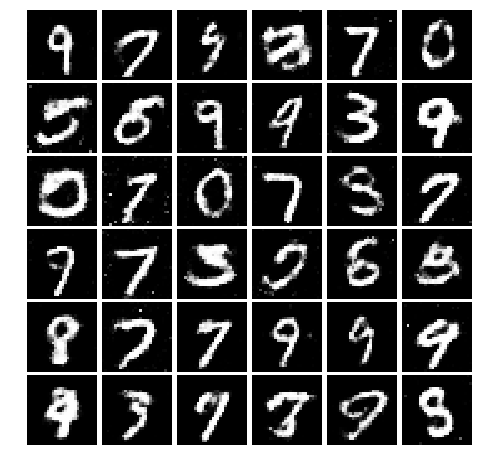

In [6]:
def sigmoid_to_tanh(x):
    return 2 * x - 1

tf.reset_default_graph()

DR = 0.3
LR = 0.0001
NUM_ITER = 10 ** 5 + 1
BATCH_SIZE = 2 ** 6
NUM_ITER_PT = int(NUM_ITER / 100)
NUM_IMG_TILE_CNT = 6
NUM_IMG_PLOT = NUM_IMG_TILE_CNT ** 2

with tf.Session() as sess:
    gan = GAN(dim_z=100, dim_g_h1=250, dim_g_h2=500, dim_x=dim_image, dim_d_h1=500, dim_d_h2=250)
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    fixed_noise = gan.generate_noise(NUM_IMG_PLOT)
    
    # Train both D and G
    num_img = 0
    for iter in xrange(NUM_ITER):
        x_batch, _ = mnist.train.next_batch(BATCH_SIZE)
        x_batch = sigmoid_to_tanh(x_batch)
        gan.train(sess, x_batch, LR, DR, train_D_only=True)
        gan.train(sess, x_batch, LR, DR)

        # Animation
        if iter % (10 ** 3) == 0:
            x_fake = gan.generate_data(sess, fixed_noise)
            plot_data(x_fake, 'plot_gan_mnist/%d.png'%num_img)
            num_img += 1
            
        # Last generation
        if iter == (NUM_ITER-1):
            plot_data(x_fake)